# Visualize the Signature data

### Load the packages

In [24]:
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime 
import cmocean
import pandas as pd
sys.path.append(os.path.join(os.getcwd(), '../functions'))
from general_functions import  read_netCDF, interpolate_nans
from scipy.interpolate import interp1d
# Uncomment to have interactive figures:
%matplotlib widget 

### Parameters

Specify the path to the data files and the list of filenames to read:

In [25]:
data_path="../data/Signature"
campaign="20250520"
level="Level2"

filepath=os.path.join(data_path,campaign,level)
filenames=os.listdir(filepath) # All files
if len(filenames)>1:
    print("More than one datafile: visualization of the first file only")
filename_str=filenames[0]

Smoothing options:

In [26]:
smoothing=True # If True, echosounder datata is smoothened on the plot, both temporally and vertically
temp_window=5 # Length of the time averaging window for smoothing
depth_window=5 # Length of the depth averaging window for smoothing

Figure saving option:

In [27]:
savefig=False # If True, all figures are exported as png

Plot parameters:

In [28]:
dt=1/(60*24) # Temporal resolution shown on the figure [days], to plot the data faster
dtick=dt*10 # Spacing between xticks

velocity_bursts="remove" # Either: "keep" (keep all echosounder data), "remove" (remove echosounder data during velocity burst measurements), "replace" (replace echosounder data by echo from velocity burst measurements)

title_size=10 # Font size of the title
start_date=''# Starting date specified as datetime(yyyy,mm,dd) or '' to use the first measurement
end_date='' # End date specified as datetime(yyyy,mm,dd) or '' to use the last measurement
maxEchodiff=20 # Maximum echo difference [dB] to scale the colormap on the figure
maxvel=[5,5,1] # Maximum east, north and upward velocities [cm/s] to scale the colormap on the figure

### Open the data file

In [29]:
nc_data, nc_genatt, nc_varatt, nc_dim=read_netCDF(os.path.join(data_path,campaign,level,filename_str))

In [30]:
tdate_echo=pd.to_datetime(nc_data["time_echo"], unit='s')
tnum_echo=nc_data["time_echo"].copy()
tdate_vel=pd.to_datetime(nc_data["time_vel"], unit='s')
tnum_vel=nc_data["time_vel"].copy()

### Separate the two echosounder datasets and interpolate to a continuous time grid

In [31]:
n_echo=int(nc_genatt["n_echograms"])
echo_interp=[]
if n_echo==2:
    tnum_interp=np.arange(tnum_echo[0],tnum_echo[-1],np.ceil(tnum_echo[2]-tnum_echo[1]))
    f1=interp1d(tnum_echo[::2],nc_data["echo_HR"][:,::2],axis=1,kind='linear', bounds_error=False, fill_value=np.nan)
    f2=interp1d(tnum_echo[1::2],nc_data["echo_HR"][:,1::2],axis=1,kind='linear', bounds_error=False, fill_value=np.nan)
    echo_interp.append(f1(tnum_interp))
    echo_interp.append(f2(tnum_interp))
else:
    tnum_interp=np.arange(tnum_echo[0],tnum_echo[-1],np.ceil(tnum_echo[1]-tnum_echo[0]))
    f=interp1d(tnum_echo,nc_data["echo_HR"],axis=1,kind='linear', bounds_error=False, fill_value=np.nan)
    echo_interp.append(f(tnum_interp))
tdate_interp=pd.to_datetime(tnum_interp,unit='s')

### Select period

Select specified period and temporal step:

In [32]:
dval_echo=int(dt*86400/(tnum_interp[1]-tnum_interp[0])) # Temporal index step

# Set starting date:
if start_date:
    if start_date<tdate_echo[-1]:
        ind_start_echo=np.where(tdate_interp>=start_date)[0][0]
        ind_start_vel=np.where(tdate_vel>=start_date)[0][0]
    else:
        ind_start_echo=0
        ind_start_vel=0
        print("WARNING: starting time is after last measurement, use first measurement instead")
else:
    ind_start_echo=0
    ind_start_vel=0

# Set end date:
if end_date:
    if end_date>tdate_echo[0]:
        ind_end_echo=np.where(tdate_interp<=end_date)[0][-1]
        ind_end_vel=np.where(tdate_vel<=end_date)[0][-1]
    else:
        ind_end_echo=len(tdate_interp)
        ind_end_vel=len(tdate_vel)
        print("WARNING: ending time is before the first measurement, use last measurement instead")   
else:
    ind_end_echo=len(tdate_interp)
    ind_end_vel=len(tdate_vel)

### Smoothing

In [33]:
Esmooth=[None]*len(echo_interp)
for ke in range(n_echo):
    if smoothing:
        Esmooth[ke]=pd.DataFrame(echo_interp[ke]).T.rolling(window=temp_window).mean().T # Temporal smoothing across columns
        Esmooth[ke]=Esmooth[ke].rolling(window=depth_window).mean().values # Depth smoothing across rows
    else:
        Esmooth[ke]=echo_interp[ke]

    # Remove NaN values for better visualization:
    Esmooth[ke]=interpolate_nans(Esmooth[ke])

In [34]:
# Remove data taken during velocity burst measurements and replace by echo data from velocity bursts:
if velocity_bursts=="remove" or velocity_bursts=="replace":
    ind_velocity=np.where([np.round(t) in np.round(tnum_vel) for t in tnum_interp])[0]
    
    # Interpolation of echo data from velocity measurements:
    if velocity_bursts=="replace":
        E_vel_avg=np.nanmean(np.stack((nc_data["echo1"],nc_data["echo2"],nc_data["echo3"],nc_data["echo4"]),axis=2),axis=2) # Average echo from velocity measurements
        f_depth=interp1d(nc_data["depth_vel"],E_vel_avg,axis=0,kind='linear', bounds_error=False, fill_value=np.nan)
        E_vel_interp=f_depth(nc_data["depth_echo"])
        f_time=interp1d(tnum_vel,E_vel_interp,axis=1,kind='linear', bounds_error=False, fill_value=np.nan)
        E_vel_interp=f_time(tnum_interp)
    
    for ke in range(n_echo):
        if velocity_bursts=="remove":
            Esmooth[ke][:,ind_velocity]=np.nan
        else:
            Esmooth[ke][:,ind_velocity]=E_vel_interp[:,ind_velocity]

### Figure 1 - Echosounder data

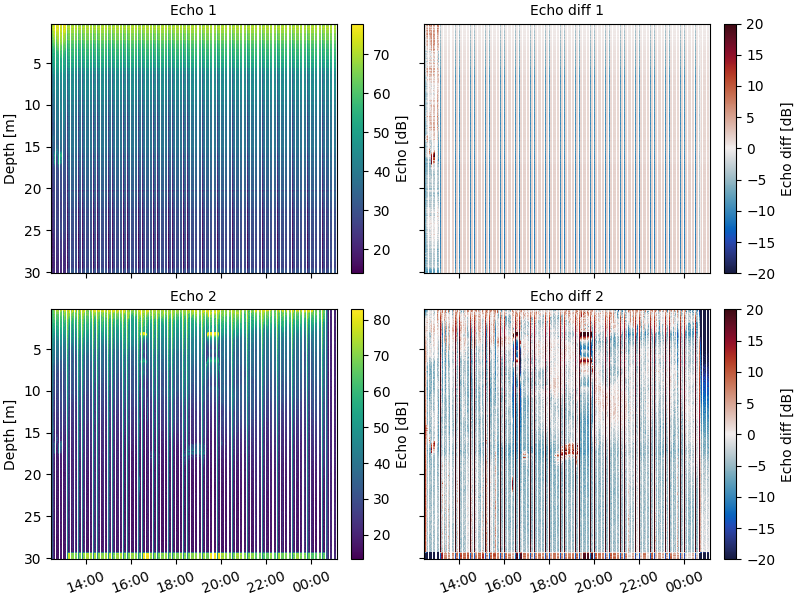

In [35]:
fig,ax=plt.subplots(n_echo,2,figsize=(8,6),sharex=True,sharey=True,layout="constrained")

for kecho in range(n_echo):  
    ind_plot=np.arange(ind_start_echo,ind_end_echo,dval_echo)
  
    hp=ax[kecho,0].pcolormesh(tdate_interp[ind_plot],nc_data["depth_echo"],Esmooth[kecho][:,ind_plot])
    ax[kecho,0].set_title("Echo "+str(kecho+1),fontsize=title_size)
    ax[kecho,0].set_ylabel("Depth [m]")
    cb=fig.colorbar(hp, location='right')
    cb.set_label("Echo [dB]",rotation=90)
    ax[kecho,0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    ax[kecho,0].tick_params(axis='x', labelrotation=20)
    

    Ediff=Esmooth[kecho][:,ind_plot]-np.array([np.nanmean(Esmooth[kecho][:,ind_plot],axis=1),]).T
    hp_diff=ax[kecho,1].pcolormesh(tdate_interp[ind_plot],nc_data["depth_echo"],Ediff,cmap=cmocean.cm.balance,vmin=-maxEchodiff,vmax=maxEchodiff)
    ax[kecho,1].set_title("Echo diff "+str(kecho+1),fontsize=title_size)
    cb_diff=fig.colorbar(hp_diff, location='right')
    cb_diff.set_label("Echo diff [dB]",rotation=90)
    ax[kecho,1].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    ax[kecho,1].tick_params(axis='x', labelrotation=20)

ax[0,0].invert_yaxis()

In [12]:
# Save fig
if savefig:
    fig.savefig("Echosounder_"+level+"_"+tdate_echo[ind_plot[0]].strftime("%Y%m%d")+"_"+tdate_echo[ind_plot[-1]].strftime("%Y%m%d")+".png",dpi=400)

### Figure 2 - Burst velocity data

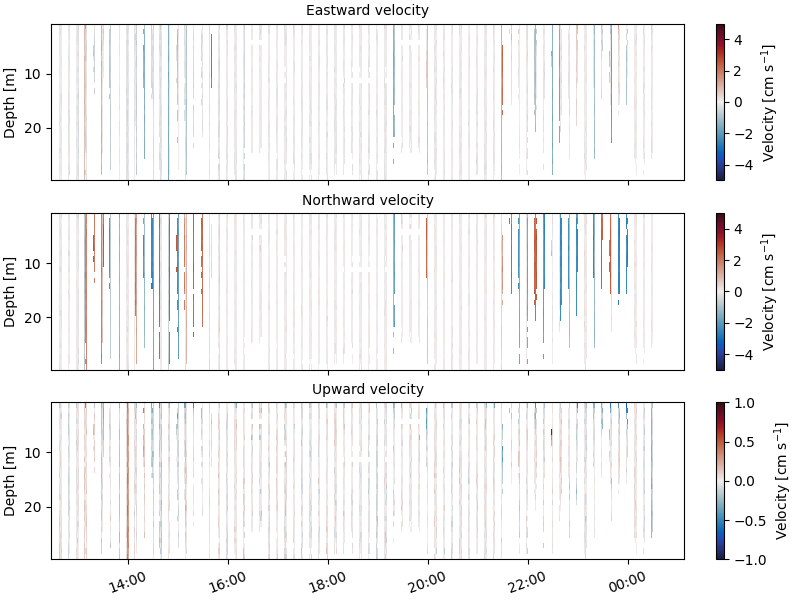

In [13]:
fig,ax=plt.subplots(3,1,figsize=(8,6),sharex=True,sharey=True,layout="constrained")
vel_data=[nc_data["u"],nc_data["v"],nc_data["w"]]*100 # cm/s
vel_name=["Eastward velocity","Northward velocity","Upward velocity"]
for kv in range(3):  
    ind_plot=np.arange(0,len(tnum_vel))
    ind_plot=ind_plot[(ind_plot>=ind_start_vel)&(ind_plot<ind_end_vel)]
    vel_array=vel_data[kv][:,ind_plot]
    
    # Put NaN data at each burst start & end to avoid interpolation by pcolormesh:
    ind_jump=np.where(np.diff(tnum_vel[ind_plot])>10)[0]
    vel_array[:,ind_jump]=np.nan
    vel_array[:,ind_jump+1]=np.nan 
    
    hp=ax[kv].pcolormesh(tdate_vel[ind_plot],nc_data["depth_vel"],vel_array,cmap=cmocean.cm.balance,vmin=-maxvel[kv],vmax=maxvel[kv])
    ax[kv].set_title(vel_name[kv],fontsize=title_size)
    ax[kv].set_ylabel("Depth [m]")
    cb=fig.colorbar(hp, location='right')
    cb.set_label("Velocity [cm s$^{-1}$]",rotation=90)
    ax[kv].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    ax[kv].tick_params(axis='x', labelrotation=20)

ax[0].invert_yaxis()

In [14]:
# Save fig
if savefig:
    fig.savefig("Burst_velocity_"+level+"_"+tdate_vel[ind_plot[0]].strftime("%Y%m%d")+"_"+tdate_vel[ind_plot[-1]].strftime("%Y%m%d")+".png",dpi=400)